# AST Version

In [ ]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [ ]:
# --------------------- Data Loading & Preprocessing ---------------------
class ESC50DataLoader:
    def __init__(self, dataset_path, sample_rate=22050, duration=5,
                 n_mels=128, hop_length=512, fmin=20, fmax=14000):
        self.dataset_path = dataset_path
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.fmin = fmin
        self.fmax = fmax
        self.data = []
        self.labels = []

    def _extract_features(self, file_path):
        # Load audio with random time stretching
        y, sr = librosa.load(file_path, sr=self.sample_rate, duration=self.duration)
        if np.random.rand() > 0.5:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))

        # Create mel spectrogram with frequency masking
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=self.n_mels,
            hop_length=self.hop_length,
            fmin=self.fmin, fmax=self.fmax
        )

        # Power-law compression instead of dB scale
        mel_spec = np.power(mel_spec, 0.3)

        # Ensure consistent shape (128, 216)
        if mel_spec.shape[1] < 216:
            mel_spec = np.pad(mel_spec, ((0,0), (0,216-mel_spec.shape[1])))
        else:
            mel_spec = mel_spec[:, :216]

        return mel_spec[..., np.newaxis]  # Add channel dimension

    def load_data(self):
        for root, _, files in os.walk(self.dataset_path):
            for file in files:
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    label = int(file.split('-')[-1].split('.')[0])
                    try:
                        mel_spec = self._extract_features(file_path)
                        self.data.append(mel_spec)
                        self.labels.append(label)
                    except Exception as e:
                        print(f"Error processing {file_path}: {str(e)}")

        self.data = np.array(self.data)
        self.labels = to_categorical(np.array(self.labels), num_classes=50)

    def split_data(self):
        # Stratified split for class balance
        return train_test_split(
            self.data, self.labels,
            test_size=0.2,
            stratify=self.labels,
            random_state=42
        )

In [ ]:
# --------------------- AST Model Components ---------------------
class SpecAugment(layers.Layer):
    @tf.function
    def call(self, specs):
        # Time warping with proper 4D cropping
        batch_size = tf.shape(specs)[0]
        crop_size = tf.stack([batch_size, 128, 200, 1])  # [B, H, W, C]
        specs = tf.image.random_crop(specs, size=crop_size)

        # Resize back to original dimensions
        specs = tf.image.resize(specs, size=(128, 216))

        # Frequency masking
        if tf.random.uniform(()) > 0.5:
            specs = tf.image.random_flip_left_right(specs)

        # Random brightness adjustment
        specs = tf.image.random_brightness(specs, max_delta=0.2)
        return specs

    def compute_output_shape(self, input_shape):
        # Maintains original shape after augmentation
        return input_shape

class ClsToken(layers.Layer):
    def build(self, input_shape):
        self.cls_token = self.add_weight(
            shape=(1, 1, input_shape[-1]),
            initializer='random_normal',
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_tokens = tf.repeat(self.cls_token, batch_size, axis=0)
        return tf.concat([cls_tokens, inputs], axis=1)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim//num_heads)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='gelu'),
            layers.Dropout(dropout),
            layers.Dense(embed_dim)
        ])
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout(attn_output)
        x = self.ln1(inputs + attn_output)
        ffn_output = self.ffn(x)
        return self.ln2(x + ffn_output)

In [ ]:
# --------------------- AST Model Architecture ---------------------
class ESC50ASTModelTrainer:
    def __init__(self, input_shape=(128, 216, 1), num_classes=50,
                 patch_size=(16, 18), embed_dim=192, num_heads=6,
                 ff_dim=384, num_layers=4, dropout=0.3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(self.input_shape)

        # Augmentation & Normalization
        # x = SpecAugment()(inputs)
        x = layers.Normalization(axis=(1, 2, 3))(inputs)

        # Patch Embedding
        x = layers.Conv2D(self.embed_dim, self.patch_size,
                         strides=self.patch_size,
                         kernel_initializer='he_normal')(x)
        num_patches = (self.input_shape[0]//self.patch_size[0]) * \
                     (self.input_shape[1]//self.patch_size[1])
        x = layers.Reshape((num_patches, self.embed_dim))(x)

        # Add CLS Token
        x = ClsToken()(x)

        # Position Embeddings
        positions = tf.range(num_patches + 1)
        pos_embed = layers.Embedding(num_patches + 1, self.embed_dim)(positions)
        x += pos_embed
        x = layers.Dropout(self.dropout)(x)

        # Transformer Encoder
        for _ in range(self.num_layers):
            x = TransformerBlock(self.embed_dim, self.num_heads,
                                self.ff_dim, self.dropout)(x)

        # Classification Head
        x = layers.LayerNormalization(epsilon=1e-6)(x[:, 0])  # CLS token
        x = layers.Dense(512, kernel_initializer='he_normal')(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        return models.Model(inputs, outputs)

    def compile_model(self, lr=5e-5):
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=lr,
            weight_decay=1e-4,
            global_clipnorm=1.0
        )
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=200, batch_size=32):
        # Adapt normalization layer
        # norm_layer = self.model.layers[2]
        # norm_layer.adapt(X_train)

        # Learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=5e-5,
            decay_steps=epochs * len(X_train) // batch_size,
            alpha=0.01
        )
        self.model.optimizer.learning_rate = lr_schedule

        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=30,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_ast_model.keras',
                save_best_only=True
            )
        ]

        # Enable XLA acceleration
        tf.config.optimizer.set_jit(True)

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            shuffle=True,
            verbose=1
        )
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def plot_history(self, history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

d:\GitHub\SED\.venv\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)



Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 910ms/step - accuracy: 0.0221 - loss: 6.7197 - val_accuracy: 0.0312 - val_loss: 4.3360
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 905ms/step - accuracy: 0.0295 - loss: 5.6743 - val_accuracy: 0.0375 - val_loss: 3.8155
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 905ms/step - accuracy: 0.0192 - loss: 5.1468 - val_accuracy: 0.0437 - val_loss: 3.7335
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 912ms/step - accuracy: 0.0164 - loss: 4.9789 - val_accuracy: 0.0875 - val_loss: 3.6461
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 938ms/step - accuracy: 0.0253 - loss: 4.7102 - val_accuracy: 0.0750 - val_loss: 3.6190
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 926ms/step - accuracy: 0.0271 - loss: 4.4833 - val_accuracy: 0.0812 - val_loss: 3.5730
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 926ms/step - accuracy: 0.0381 - loss: 4.4017 - val_accuracy: 0.0875 - val_loss: 3.5188
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 935ms/step - accuracy: 0.0317 - loss: 4.3097 -

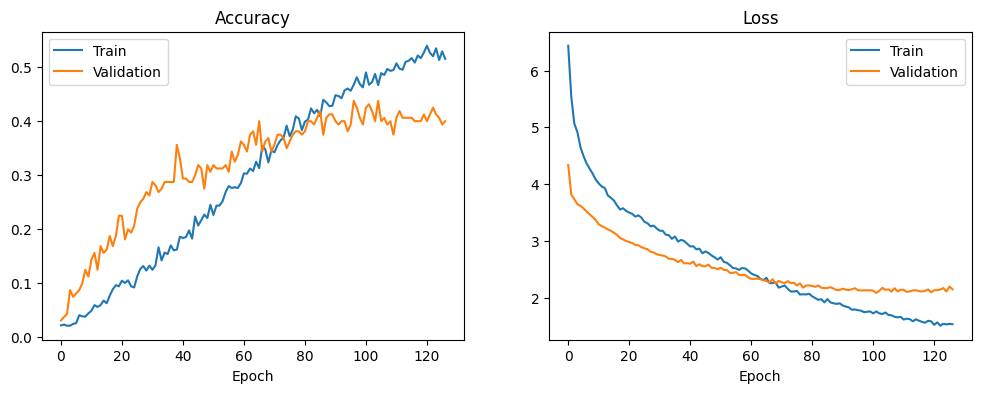

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4578 - loss: 1.9197

Test Accuracy: 44.75% | Test Loss: 1.9054


In [ ]:
# --------------------- Training Execution ---------------------

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load and preprocess data
data_loader = ESC50DataLoader(
    dataset_path=os.getenv('ESC_50_dataset'),
    n_mels=128,
    hop_length=512
)
data_loader.load_data()
X_train, X_test, y_train, y_test = data_loader.split_data()
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

# Verify input dimensions
assert X_train.shape[1:] == (128, 216, 1), \
    f"Invalid input shape: {X_train.shape[1:]}"

# Initialize and train model
trainer = ESC50ASTModelTrainer()
trainer.compile_model(lr=5e-5)
history = trainer.train(
    X_train, y_train,
    X_val, y_val,
    epochs=200,
    batch_size=48
)

# Evaluate and save
trainer.plot_history(history)
test_loss, test_acc = trainer.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.2%} | Test Loss: {test_loss:.4f}")
trainer.model.save('esc50_ast_final.keras')